# Splay木(平衡二分探索木)
## 概要
木が平衡に保たれるため、高速にアクセスできる二分探索木
### 計算量
追加、削除、探索: $O(logN)$

## 参考
- [【木マスター養成講座】7-1. Splay木ってなに〜？説明編【競プロかつっぱ】](https://www.youtube.com/watch?v=M6LcINhgXeM)
- [【木マスター養成講座】7-2. Splay木ってなに〜？実装編１【競プロかつっぱ】](https://www.youtube.com/watch?v=M6LcINhgXeM&t=0s)
- https://onlinejudge.u-aizu.ac.jp/solutions/problem/ITP2_1_A/review/4078592/catupper/C++14

## 方針

### クラス設計
Nodeに対応するclassを作る
```
class Node:
    val
    |- left, right, parent: 親と子のポインタ
    |- size: 部分木のサイズ
    |_ value: 値
    func
    |- rotate(): 回転
    |- splay(): meを上に上げる
    |_ update(): サイズの更新
```

### 回転

```
   pp-> o
        |
    p-> o
       / \
 me-> o   B
     / \
    A   C

       ↓

  pp-> o
       |
  me-> o
      / \
     A   o <-p
        / \
       C   B

```
- 全部で6つの代入
1. `pp.left = pp.right = me` ## ppがいるか確認
1. `me.parent = pp`
1. `me.right = p`
1. `p.parent = me`
1. `p.left = C`
1. `C.parent = p` ## Cがいるか確認

In [99]:
from graphviz import Digraph

In [100]:
class Node:
    """スプレー木のノード
    Attributes:
        left, right, parent (Node): 親と子のノード
        size (int): 部分木のサイズ
        value: 値
    """
    def __init__(self, val):
        self.val = val
        self.left = None
        self.right = None
        self.parent = None
        self.size = 1
    
    def __repr__(self):
        res = "Node(val:{}, left:{}, right:{}, parent:{})".format(
            self.val,
            self.left.val if self.left else None,
            self.right.val if self.right else None,
            self.parent.val if self.parent else None
        )
        return res

    def state(self):
        if not self.parent:
            return 0
        if self.parent.left == self:
            return 1
        if self.parent.right == self:
            return -1
        return 0

In [101]:
class BSTree:
    def __init__(self):
        self.root = None
    
    def insert(self, key):
        """要素の挿入を行う
        Args:
            key : 追加する要素
        """
        if self.root == None:
            self.root = Node(key)

        # 接点(parent)の探索
        parent, result = self.search(key)

        if result: return
        
        # 要素の挿入
        node = Node(key)
        node.parent = parent
        if node.val < parent.val:
            parent.left = node
        else:
            parent.right = node

    def delete(self, key):
        target, result = self.search(key)

        if result:
            self.delete_node(target)
    
    def delete_node(self, node):
        """要素の削除を行う

        Args:
            node (Node): 削除する要素
        """
        if node.left == None:
            self.transplant(node, node.right)
        elif node.right == None:
            self.transplant(node, node.left)
        else:
            y = self.search_min(node.right)

            # yがnodeの直下にない場合、yをnodeの真下に持ってくる必要がある
            if y.parent != node:
                # 一旦yを切り離す
                self.transplant(y, y.right)
                # yの右側にnodeの右側を貼り付ける
                y.right = node.right
                y.right.parent = y

            # yの左側にnodeの左側を貼り付ける
            self.transplant(node, y)
            y.left = node.left
            y.left.parent = y
    
    def transplant(self, u, v):
        """ノードの付け替えを行う

        Args:
            u (Node): 削除されるノード
            v (Node): 子となるノード
        """
        if u.parent == None:
            self.root = v
        elif u.parent.left == u:
            u.parent.left = v
        else:
            u.parent.right = v
        if v != None:
            v.parent = u.parent  # 親の更新
        
    @staticmethod
    def search_min(node) -> Node:
        """木の最小値の探索を行う

        Args:
            node (Node): 部分木のroot
        Returns:
            Node: 木の中で最小の値
        """
        while node.left:
            node = node.left
        
        return node
    
    def search(self, key) -> Node:
        """木の要素を探索する
        
        Args:
            key (Node): 探索する値
        Returns:
            Node: 見つかったノード
        """

        last = None
        node = self.root

        while node:
            if node.val == key:
                return node, True
            
            last = node
            if key < node.val:
                node = node.left
            else:
                node = node.right
        
        return last, False
    
    def traverse(self, node=None):
        """木を巡回し、小さい順に値を返すジェネレータ

        Args:
            node=None (Node): 開始ノード
        Yields:
            Node: 見つかったノード
        """
        if node == None:
            node = self.root
        
        if node.left:
            yield from self.traverse(node.left)
        
        yield node

        if node.right:
            yield from self.traverse(node.right)
    
    def as_graph(self, format="png"):
        """グラフを可視化
        
        Args:
            format="png" (str): graphvizの出力形式
        Returns:
            graphviz.Digraph
        """

        graph = Digraph(format=format)
        fill = 0
        for node in self.traverse():
            v = str(node.val)
            graph.node(v)
        
        for node in self.traverse():
            v = str(node.val)
            if node.left:
                l = str(node.left.val)
                graph.edge(v, l)

            if node.right:
                r = str(node.right.val)
                graph.edge(v, r)
        
        return graph

In [106]:
class SplayTree(BSTree):
    def __init__(self):
        super().__init__()

    def search(self, key) -> Node:
        """木の要素を探索する
        
        Args:
            key (Node): 探索する値
        Returns:
            Node: 見つかったノード
        """

        last = None
        node = self.root

        while node:
            if node.val == key:
                self.splay(node)
                return node, True
            
            last = node

            if key < node.val:
                node = node.left
            else:
                node = node.right
        
        self.splay(last)
        return last, False
    
    def rotate(self, node):
        p = node.parent
        pp = p.parent

        if p.left == node:
            c = node.right
            node.right = p
            p.left = c
        else:
            c = node.left
            node.left = p
            p.right = c

        if pp and pp.left == p:
            pp.left = node
        if pp and pp.right == p:
            pp.right = node
        
        node.parent = pp
        p.parent = node
        if c:
            c.parent = p

    def splay(self, node):
        while node.state() != 0:
            if node.parent.state() == 0:
                self.rotate(node)
            elif node.state() == node.parent.state():
                self.rotate(node.parent)
                self.rotate(node)
            else:
                self.rotate(node)
                self.rotate(node)
            self.root = node


## テスト

Node(val:10, left:None, right:None, parent:None)
Node(val:10, left:5, right:None, parent:None)
Node(val:5, left:None, right:8, parent:None)
Node(val:8, left:5, right:20, parent:None)
(Node(val:20, left:8, right:None, parent:None), False)
(Node(val:5, left:None, right:8, parent:None), True)
(Node(val:8, left:5, right:20, parent:None), True)
(Node(val:20, left:8, right:None, parent:None), True)
(Node(val:20, left:8, right:None, parent:None), False)


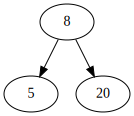

In [107]:
tree = SplayTree()

tree.insert(10)
print(tree.root)
tree.insert(5)
print(tree.root)
tree.insert(8)
print(tree.root)
tree.insert(20)
print(tree.root)

# 存在する要素
print(tree.search(10))
print(tree.search(5))
print(tree.search(8))
print(tree.search(20))

# 存在しない要素
print(tree.search(100))

# 削除
tree.delete(10)

# 表示
tree.as_graph()


In [109]:
tree = SplayTree()

for i in range(10):
    tree.insert(i)

for node in tree.traverse():
    print(node)

graph = tree.as_graph()
graph.render("./images/splaytree_worst1")

tree.search(2)
graph = tree.as_graph()
graph.render("./images/splaytree_worst2")

tree.search(5)
graph = tree.as_graph()
graph.render("./images/splaytree_worst3")

tree.search(4)
graph = tree.as_graph()
graph.render("./images/splaytree_worst4")

Node(val:0, left:None, right:None, parent:1)
Node(val:1, left:0, right:None, parent:2)
Node(val:2, left:1, right:None, parent:3)
Node(val:3, left:2, right:None, parent:4)
Node(val:4, left:3, right:None, parent:5)
Node(val:5, left:4, right:None, parent:6)
Node(val:6, left:5, right:None, parent:7)
Node(val:7, left:6, right:None, parent:8)
Node(val:8, left:7, right:9, parent:None)
Node(val:9, left:None, right:None, parent:8)


'images/splaytree_worst4.png'

![splay](./images/splaytree_worst1.png)

![splay](./images/splaytree_worst2.png)

![splay](./images/splaytree_worst3.png)

![splay](./images/splaytree_worst4.png)